In [1]:
import sys
import os


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import importlib
from sklearn.decomposition import PCA

path_src = os.path.abspath('../../../src')

# Agregar esa ruta al sys.path si no está ya
if path_src not in sys.path:
    sys.path.append(path_src)

# Importar utils normalmente
import utils
importlib.reload(utils)

# Importar funciones específicas
from utils import (
    kmeans_clustering_mlflow,
    transform_pca,
    silhouette_analysis,
    elbow_method,
    plot_davies_bouldin_scores,
    evaluar_calinski_harabasz
)


In [2]:
rfm_clientes_extranjeros = pd.read_csv('../../../dataset/rfm_clientes_extranjeros.csv')



print(rfm_clientes_extranjeros.columns)

print("cantidad de columnas: ", len(rfm_clientes_extranjeros.columns))

print("cantidad de filas: ", len(rfm_clientes_extranjeros))


Index(['id_cliente', 'Recency', 'Frequency', 'Monetary', 'horario_promedio',
       '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
       '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
       '2011-12'],
      dtype='object')
cantidad de columnas:  18
cantidad de filas:  418


In [3]:
print('rfm_clientes_extranjeros',rfm_clientes_extranjeros.columns)

rfm_clientes_extranjeros Index(['id_cliente', 'Recency', 'Frequency', 'Monetary', 'horario_promedio',
       '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
       '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
       '2011-12'],
      dtype='object')


In [133]:
rfm_clientes_extranjeros.head()

,id_cliente,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
0,12347.0,3,7,4310.00,12,711.79,475.39,0.0,0.00,636.25,0.0,382.52,0.0,584.91,0.0,1294.32,0.00,224.82
1,12348.0,76,4,1437.24,15,652.80,187.44,0.0,0.00,327.00,0.0,0.00,0.0,0.00,270.0,0.00,0.00,0.00
2,12349.0,19,1,1457.55,9,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,1457.55,0.00
3,12350.0,311,1,294.40,16,0.00,0.00,294.4,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00
4,12352.0,37,7,1385.74,14,0.00,0.00,296.5,345.01,0.00,0.0,0.00,0.0,0.00,512.5,0.00,231.73,0.00


In [134]:
# Limpieza de outliers usando el método IQR para Recency, Frequency y Monetary
def remove_outliers_iqr(df, columns):
    """
    Elimina outliers usando el método IQR (Interquartile Range)
    """
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtramos los outliers
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# Columnas a limpiar
columns_to_clean = ['Recency', 'Frequency', 'Monetary']

# Mostrar estadísticas antes de la limpieza
print("Estadísticas ANTES de la limpieza de outliers:")
print(rfm_clientes_extranjeros[columns_to_clean].describe())
print(f"\nCantidad de registros antes: {len(rfm_clientes_extranjeros)}")


# Aplicar limpieza de outliers
rfm_clientes_extranjeros_clean = remove_outliers_iqr(rfm_clientes_extranjeros, columns_to_clean)

print('cantidad de registros despues de la limpieza de outliers: ', len(rfm_clientes_extranjeros_clean))



Estadísticas ANTES de la limpieza de outliers:
          Recency   Frequency       Monetary
count  418.000000  418.000000     418.000000
mean    96.409091    4.361244    3575.053397
std    104.434586   11.182426   17389.197213
min      1.000000    1.000000      45.000000
25%     19.250000    1.000000     408.235000
50%     54.000000    2.000000     927.930000
75%    138.500000    4.000000    2408.952500
max    374.000000  198.000000  279138.020000

Cantidad de registros antes: 418
cantidad de registros despues de la limpieza de outliers:  320


In [135]:
id_cliente= rfm_clientes_extranjeros_clean['id_cliente'].copy()

id_cliente.head()

1    12348.0
2    12349.0
3    12350.0
4    12352.0
5    12353.0
Name: id_cliente, dtype: float64

In [136]:
rfm_clientes_extranjeros_clean.drop(columns=['id_cliente'], inplace=True)

In [137]:
rfm_clientes_extranjeros_clean

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
1,76,4,1437.24,15,652.8,187.44,0.00,0.00,327.0,0.0,0.00,0.00,0.00,270.0,0.0,0.00,0.0
2,19,1,1457.55,9,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,1457.55,0.0
3,311,1,294.40,16,0.0,0.00,294.40,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0
4,37,7,1385.74,14,0.0,0.00,296.50,345.01,0.0,0.0,0.00,0.00,0.00,512.5,0.0,231.73,0.0
5,205,1,89.00,17,0.0,0.00,0.00,0.00,0.0,89.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,152,2,2389.10,9,0.0,0.00,0.00,0.00,0.0,0.0,1171.46,1217.64,0.00,0.0,0.0,0.00,0.0
414,281,1,387.31,8,0.0,0.00,0.00,387.31,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0
415,23,4,1165.09,8,0.0,0.00,0.00,0.00,0.0,0.0,703.16,0.00,173.50,0.0,0.0,288.43,0.0
416,299,1,889.24,12,0.0,0.00,889.24,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0


### Reduccion de dimensionalidad

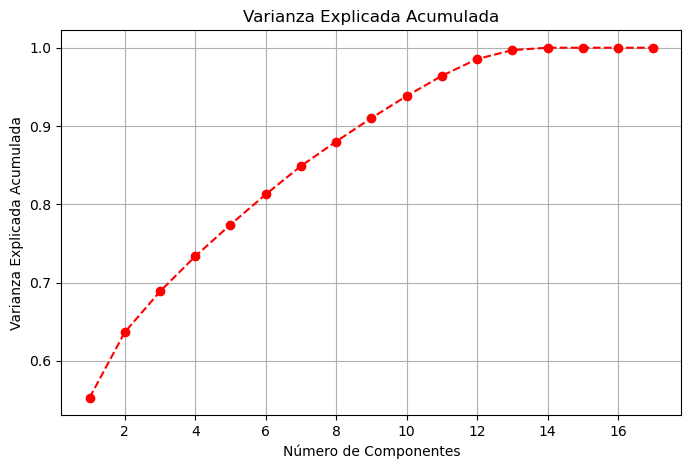

In [138]:
pca=PCA()

pca.fit(rfm_clientes_extranjeros_clean)

var_exp=pca.explained_variance_ratio_

# Graficar varianza acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_exp)+1), var_exp.cumsum(), marker='o', linestyle='--', color='red')
plt.ylabel('Varianza Explicada Acumulada')
plt.xlabel('Número de Componentes')
plt.title('Varianza Explicada Acumulada')
plt.grid()
plt.show()

In [139]:
componentes = transform_pca(rfm_clientes_extranjeros_clean, 5)

# dichas compoenentes la transformamos en un dataframe de pandas , con los mismos indices que el dataframe original , para hacer un analisis psoteriormente de los grupos que forma k-means
dataframe_pca = pd.DataFrame(componentes, columns=['PC1', 'PC2','PC3','PC4','PC5'],index=rfm_clientes_extranjeros_clean.index)

dataframe_pca.head()

,PC1,PC2,PC3,PC4,PC5
1,-0.166507,0.034653,0.320308,0.097443,-0.100628
2,-0.225233,-0.216347,-0.301811,-0.390178,0.204606
3,0.679060,0.311728,0.397675,0.026603,-0.024185
4,-0.528891,0.078460,0.284232,0.311761,-0.303863
5,0.512304,0.017170,0.460454,0.027821,0.015569


### k-means

#### Seleccion de cluster con analisis de silueta para k-means

Para n_clusters = 2, el silhouette promedio es: 0.2965
Para n_clusters = 3, el silhouette promedio es: 0.3142
Para n_clusters = 4, el silhouette promedio es: 0.2423
Para n_clusters = 5, el silhouette promedio es: 0.2451
Para n_clusters = 6, el silhouette promedio es: 0.2604
Para n_clusters = 7, el silhouette promedio es: 0.2469
Para n_clusters = 8, el silhouette promedio es: 0.2448
Para n_clusters = 9, el silhouette promedio es: 0.2454
Para n_clusters = 10, el silhouette promedio es: 0.2340
Para n_clusters = 11, el silhouette promedio es: 0.2359
Para n_clusters = 12, el silhouette promedio es: 0.2361
Para n_clusters = 13, el silhouette promedio es: 0.2375
Para n_clusters = 14, el silhouette promedio es: 0.2410


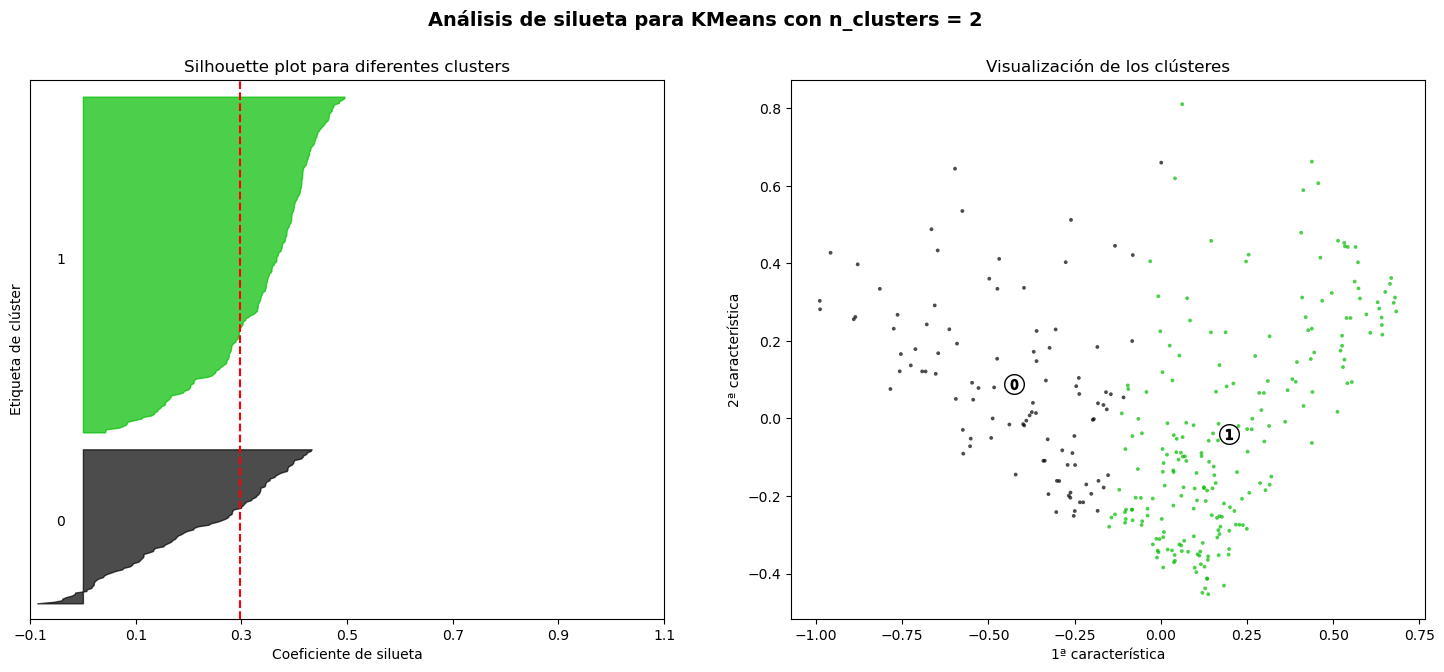

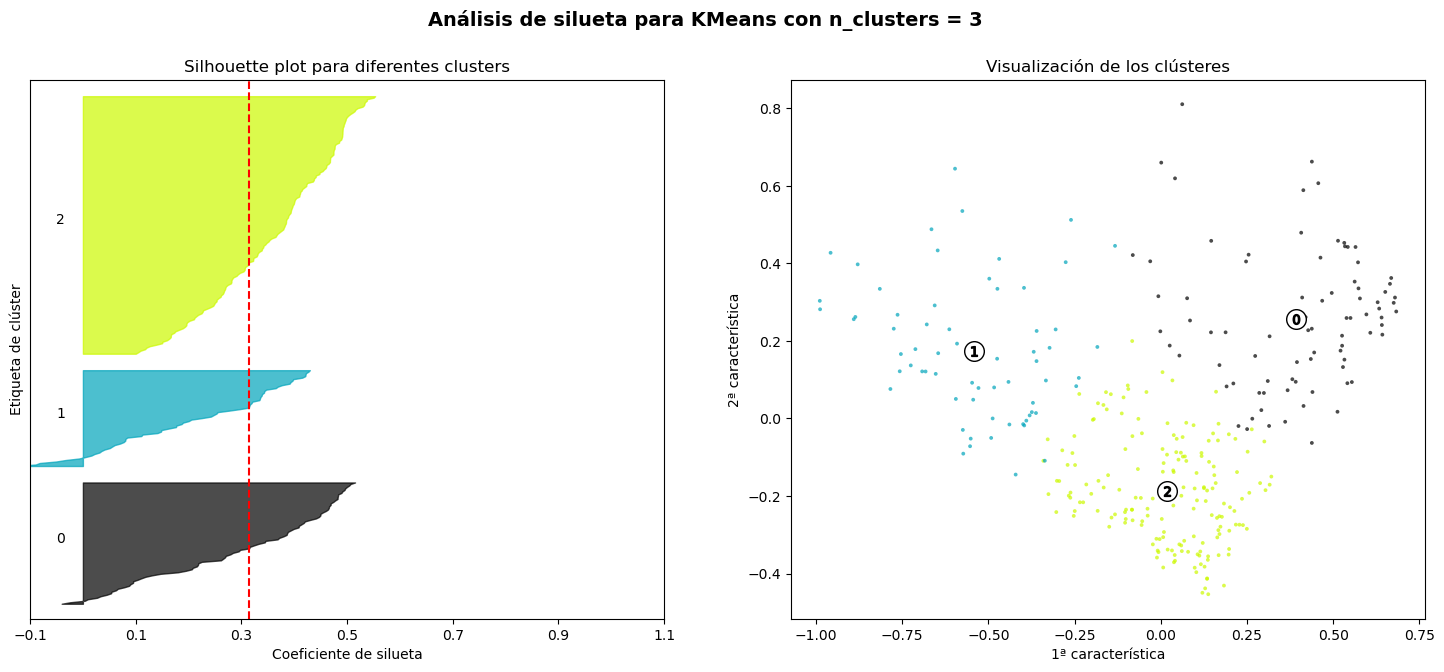

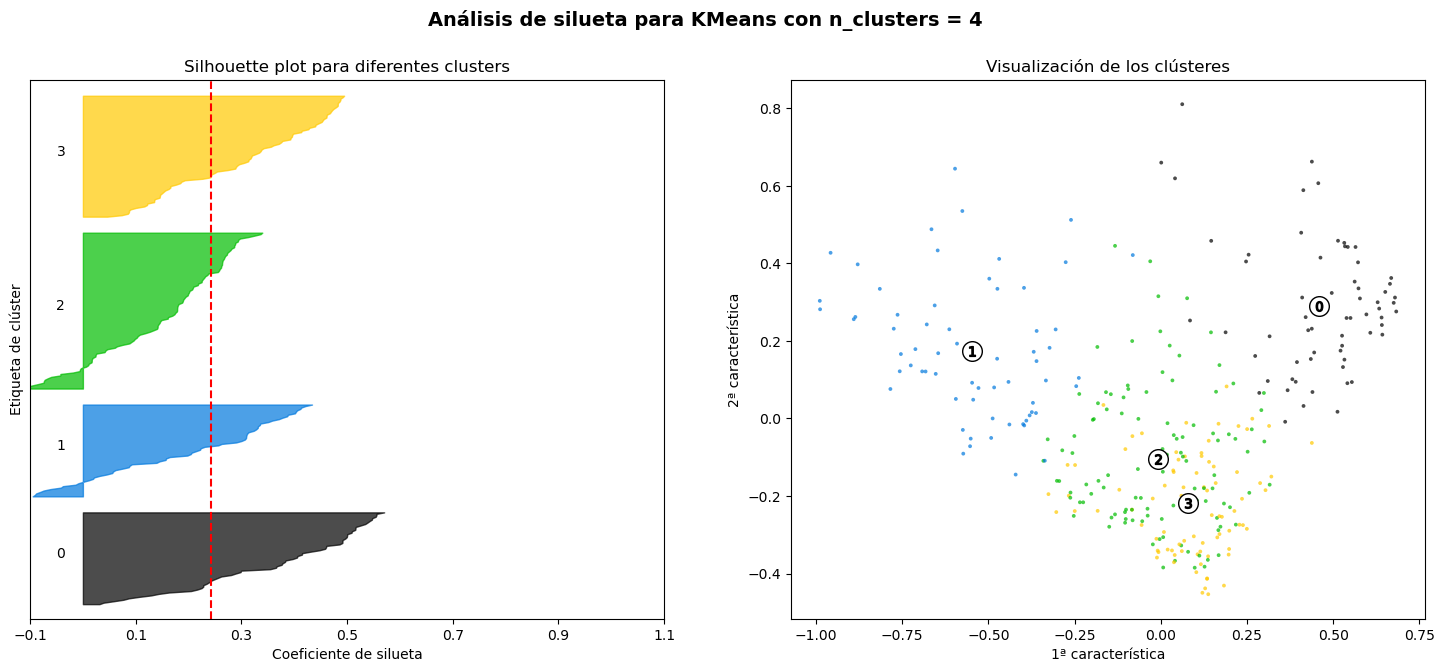

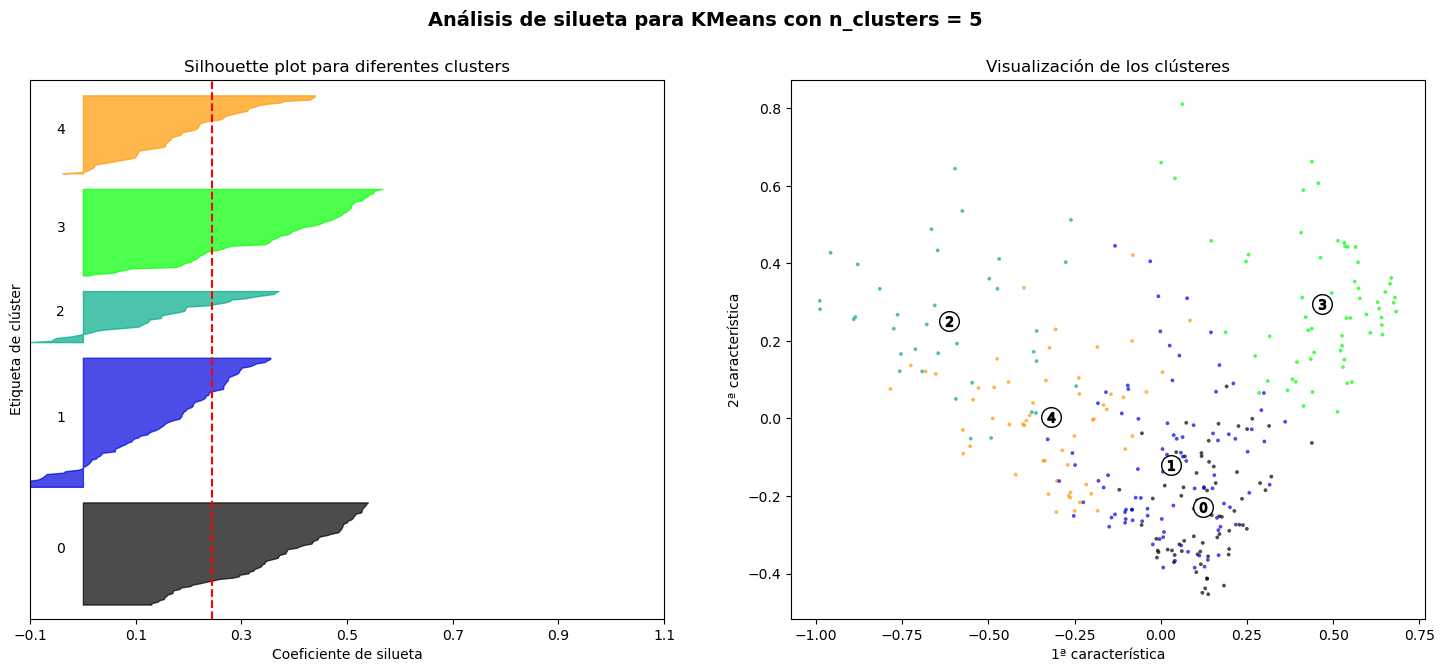

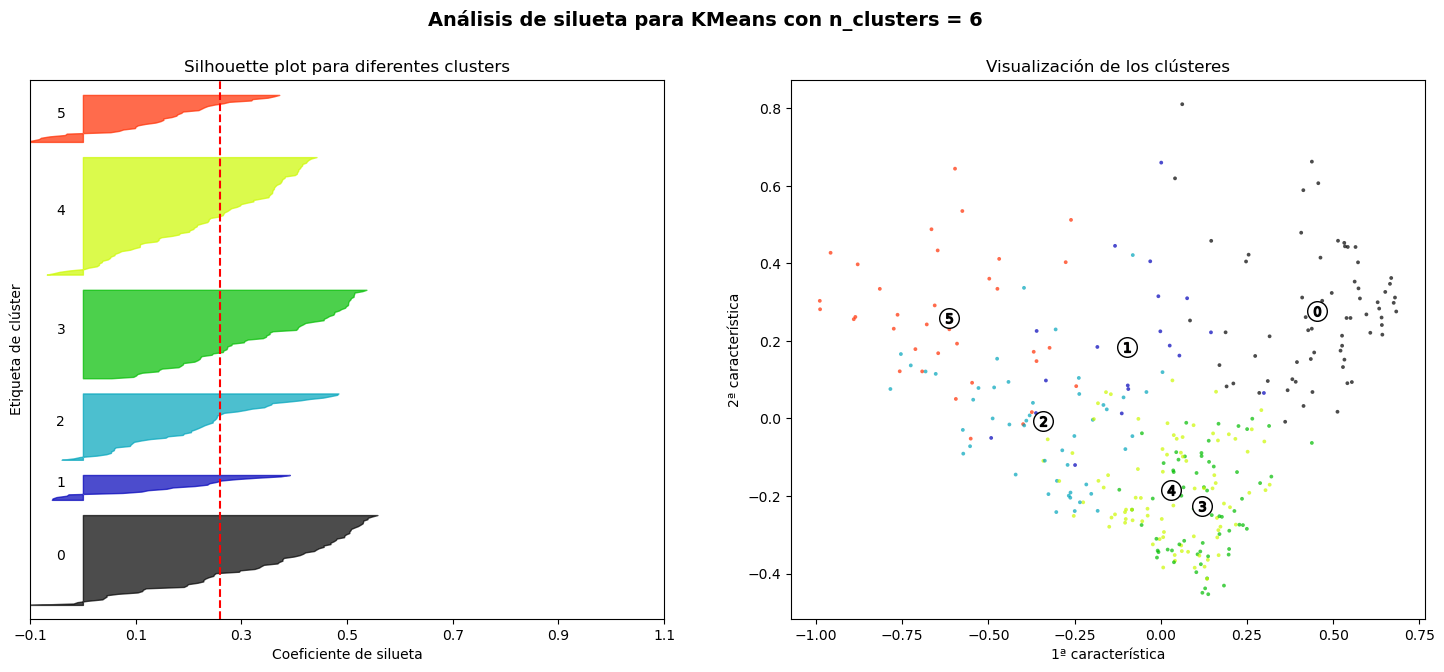

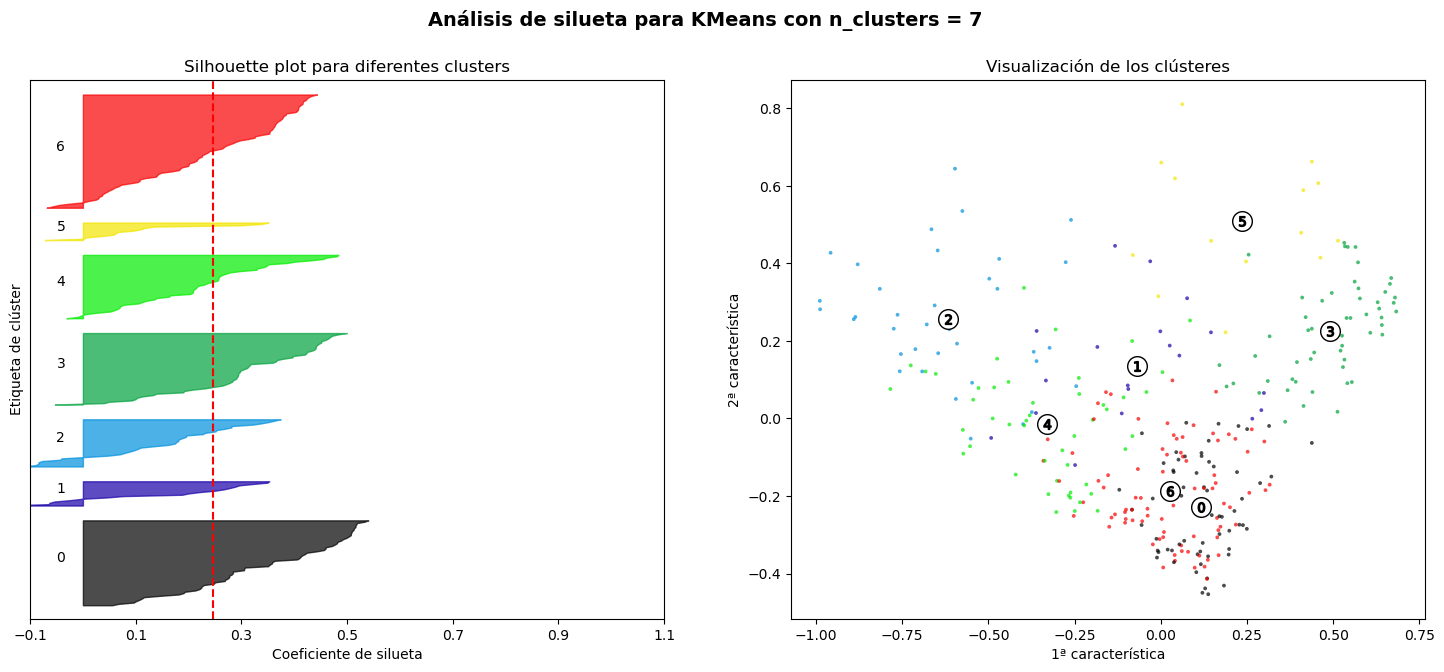

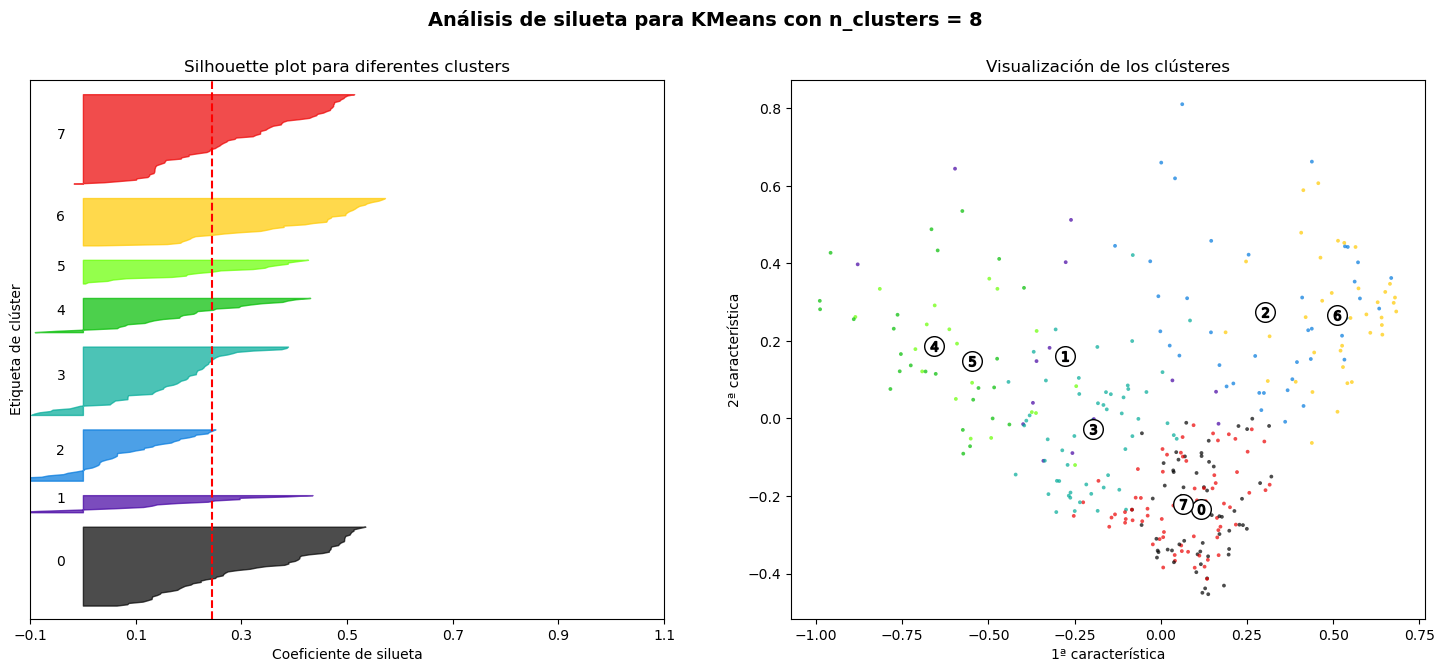

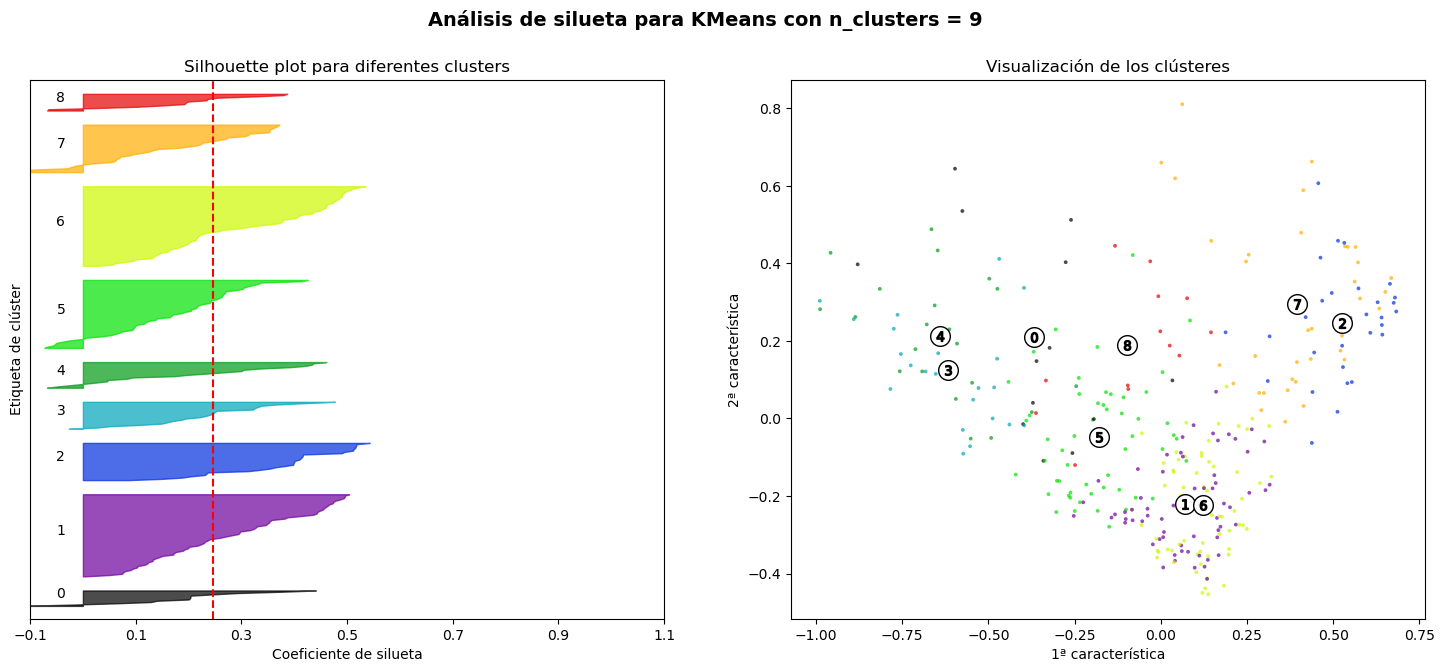

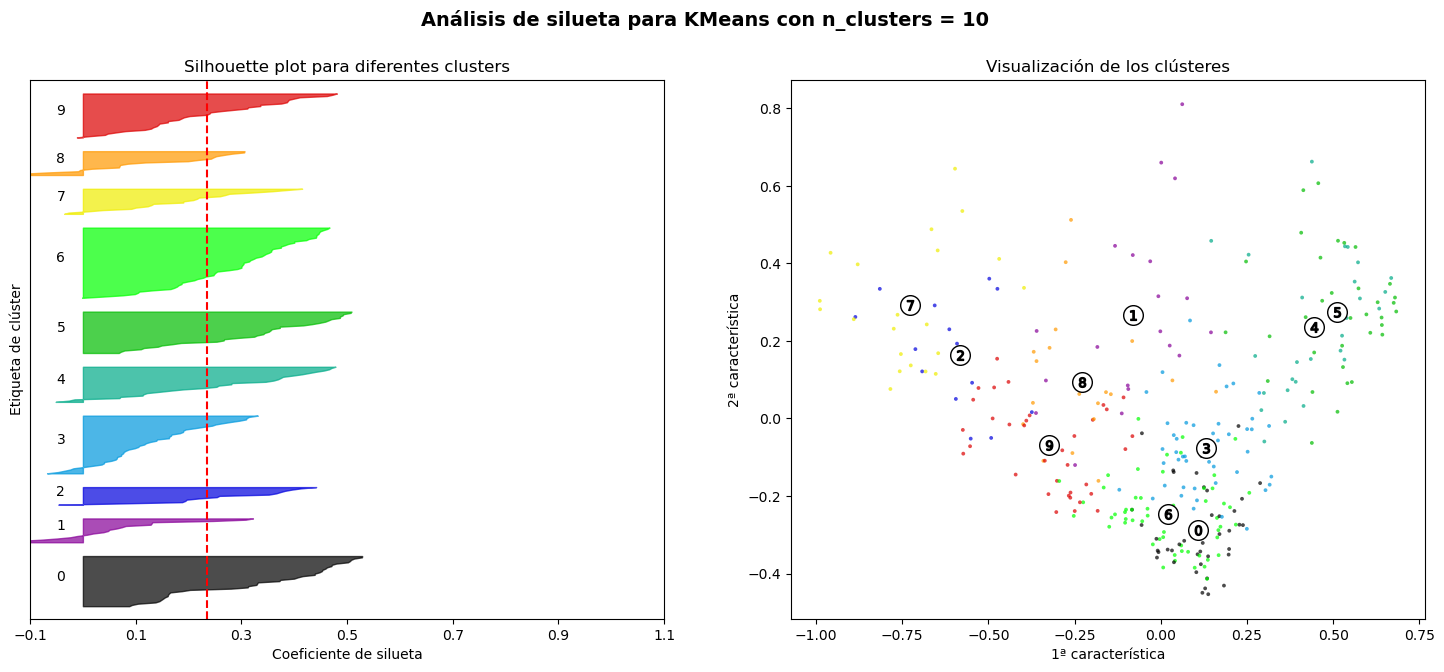

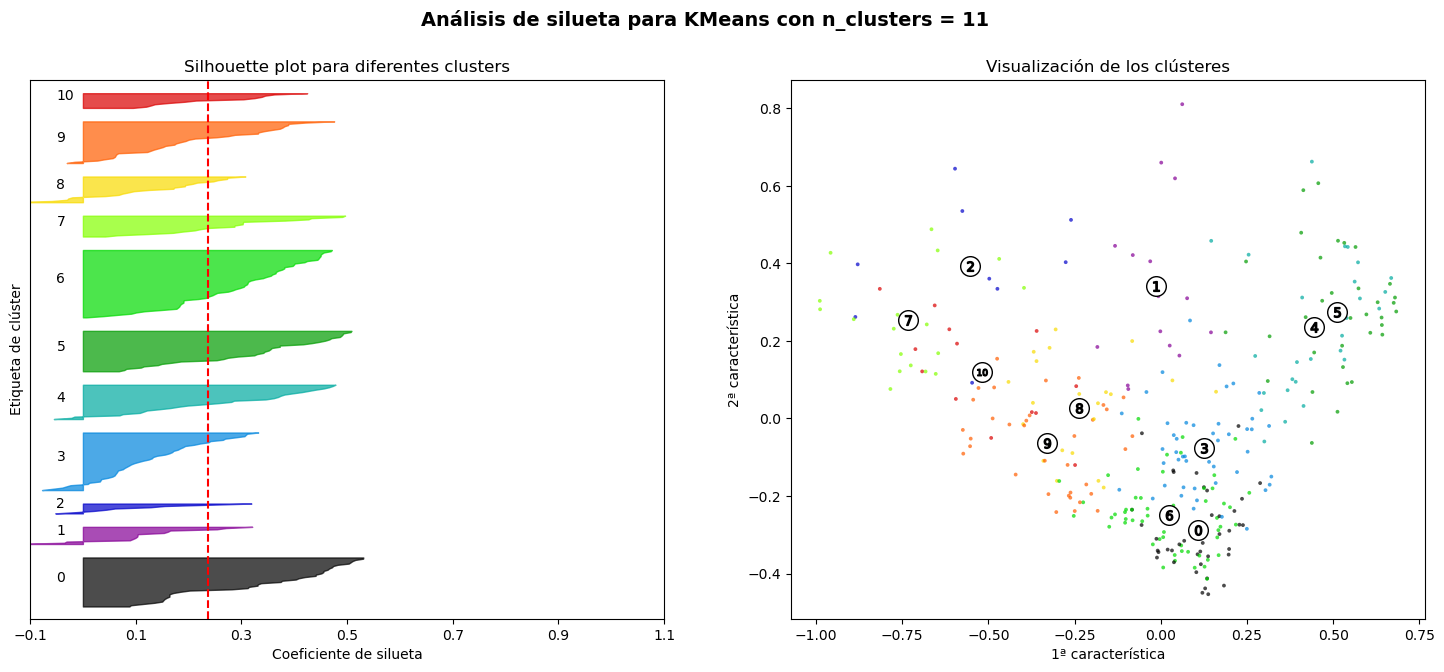

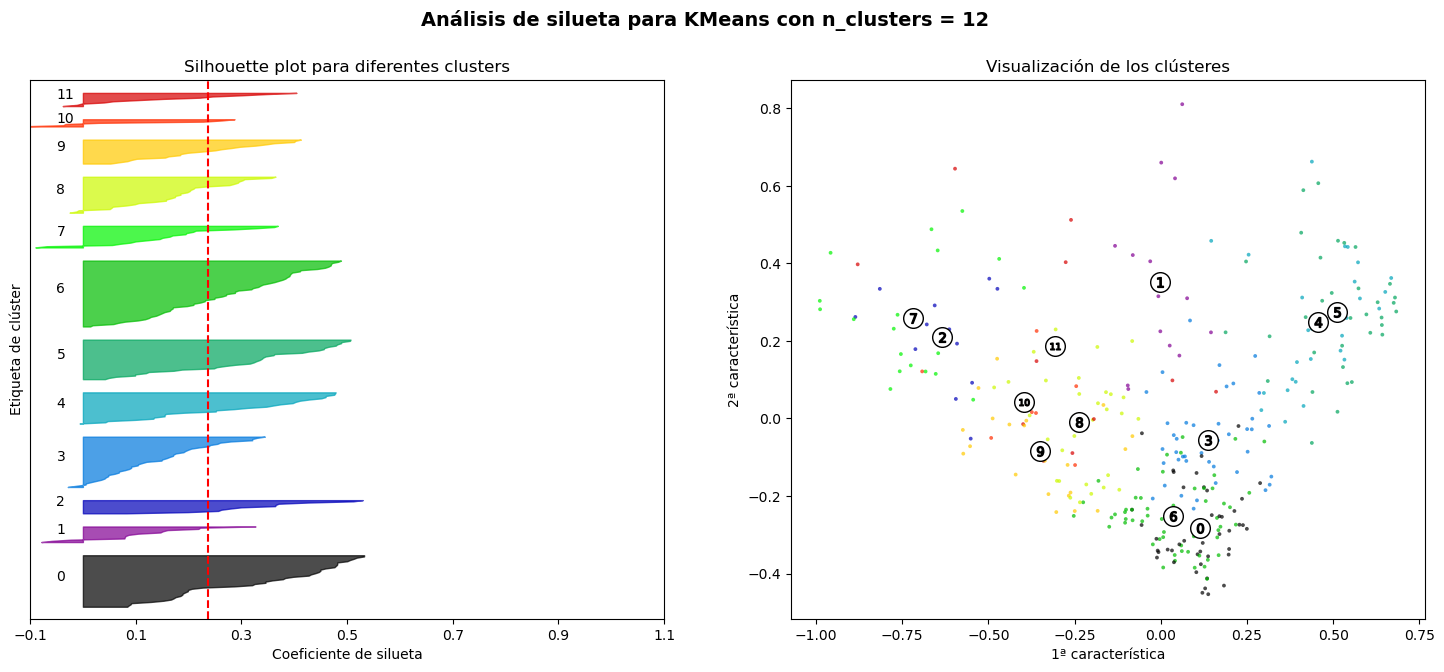

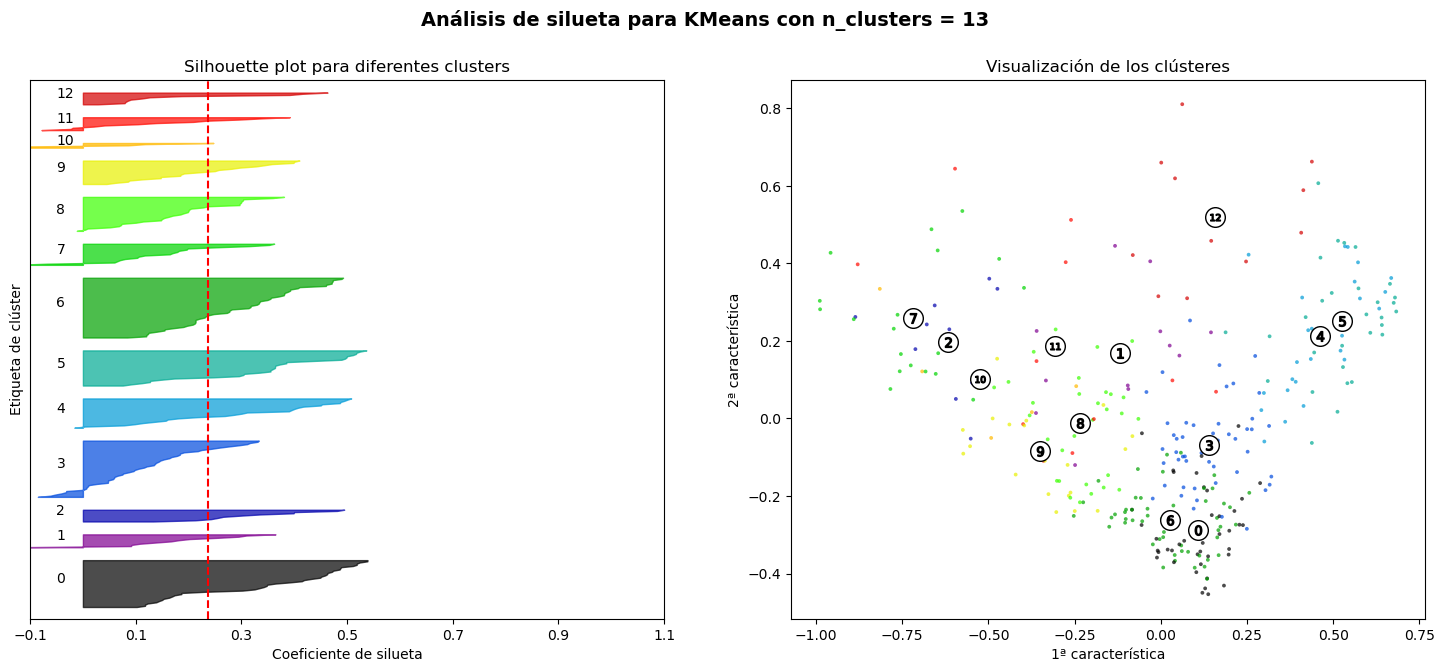

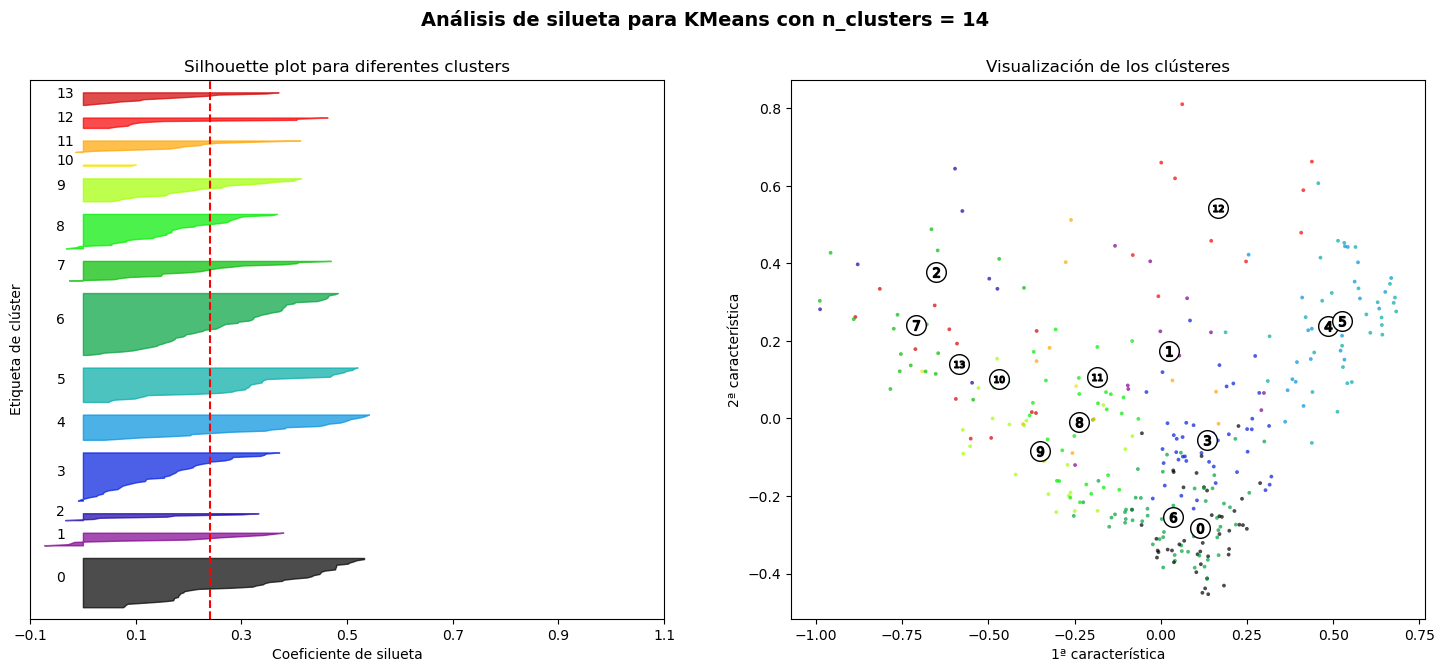

In [140]:
average_silhouette=silhouette_analysis(dataframe_pca.values, range(2, 15))

average_cluster=pd.DataFrame({'n_clusters':range(2,15),'average_silhouette':average_silhouette})


#### metodo del codo

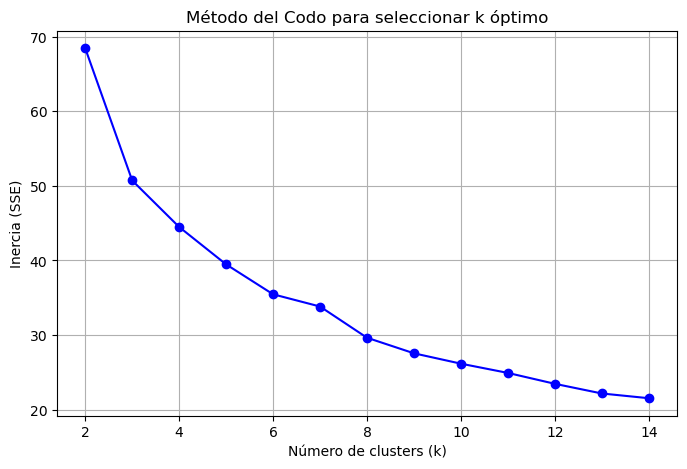

In [141]:
inertias=elbow_method(dataframe_pca.values, range(2, 15))

#### davies bouldin

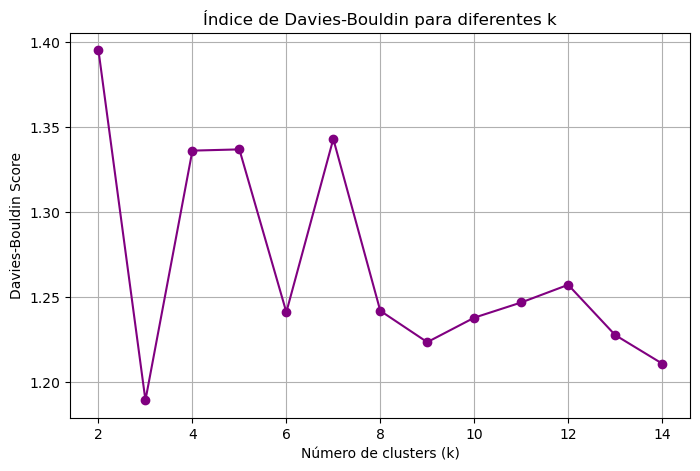

{2: np.float64(1.3949863969450342), 3: np.float64(1.1890347637184953), 4: np.float64(1.3359059670680729), 5: np.float64(1.3366302244058066), 6: np.float64(1.2408418296443113), 7: np.float64(1.342778084915771), 8: np.float64(1.2416597240543141), 9: np.float64(1.2232060036630834), 10: np.float64(1.2375937294723651), 11: np.float64(1.2465484655678056), 12: np.float64(1.2569421818565307), 13: np.float64(1.2274039779667585), 14: np.float64(1.2106220664085836)}


In [142]:
db_scores=plot_davies_bouldin_scores(dataframe_pca.values, range(2, 15))

print(db_scores)

#### Calinski-Harabasz

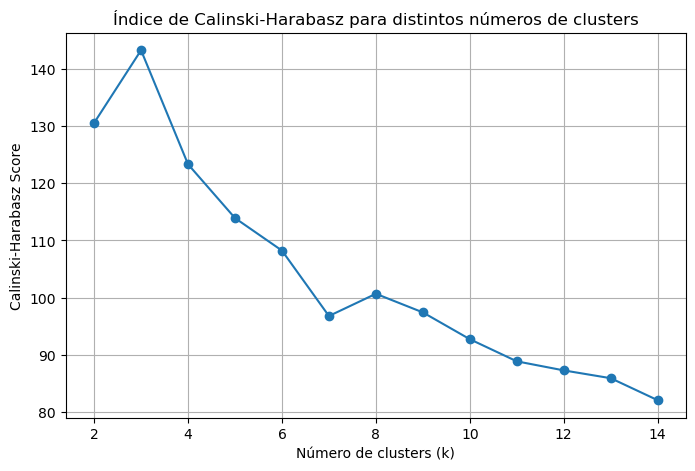

[np.float64(130.51094409843037), np.float64(143.2129363159778), np.float64(123.29760386766438), np.float64(113.90361566109229), np.float64(108.22231082104881), np.float64(96.79769639785113), np.float64(100.68099760939073), np.float64(97.42732706187954), np.float64(92.74541105271095), np.float64(88.88264510947566), np.float64(87.30064442963575), np.float64(85.93564122600381), np.float64(82.09190632681786)]


In [143]:
ch_scores=evaluar_calinski_harabasz(dataframe_pca.values, range(2, 15))

print(ch_scores)

#### K-means con 3 cluster

Run ID final clustering: 6a9e29fff57b4374bf32ee93794ff320
🏃 View run Final_Clustering_k=3 at: http://localhost:5000/#/experiments/302917147741213049/runs/6a9e29fff57b4374bf32ee93794ff320
🧪 View experiment at: http://localhost:5000/#/experiments/302917147741213049


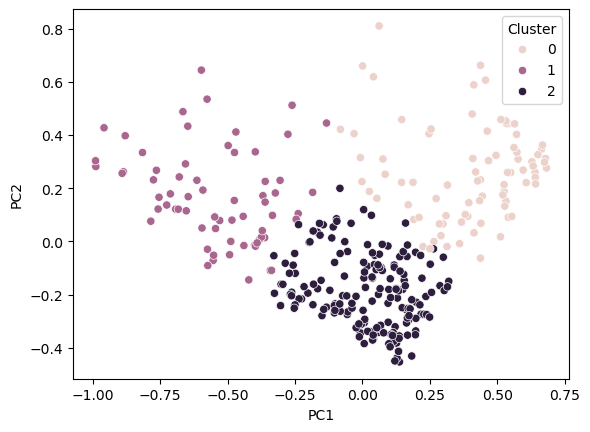

In [144]:
data_pca_cluster=kmeans_clustering_mlflow(dataframe_pca, ['PC1', 'PC2','PC3','PC4','PC5'],10,3,'K-MEANS-CLIENTES-EXTRANJEROS')


sns.scatterplot(data=data_pca_cluster,x='PC1',y='PC2',hue='Cluster')
plt.show()



In [145]:
data_pca_cluster

,PC1,PC2,PC3,PC4,PC5,Cluster
1,-0.166507,0.034653,0.320308,0.097443,-0.100628,2
2,-0.225233,-0.216347,-0.301811,-0.390178,0.204606,2
3,0.679060,0.311728,0.397675,0.026603,-0.024185,0
4,-0.528891,0.078460,0.284232,0.311761,-0.303863,1
5,0.512304,0.017170,0.460454,0.027821,0.015569,0
...,...,...,...,...,...,...
413,-0.132874,0.445047,-0.363831,-0.674213,-0.232508,1
414,0.562137,0.352835,-0.377357,0.030591,-0.013102,0
415,-0.328158,-0.053952,-0.385782,0.046072,0.011969,2
416,0.564619,0.442068,0.026324,0.002874,-0.061769,0


In [146]:

id_cliente.index = data_pca_cluster.index

In [147]:
data_pca_cluster['id_cliente'] = id_cliente

In [148]:
data_pca_cluster = data_pca_cluster[['id_cliente', 'PC1', 'PC2','PC3','PC4','PC5', 'Cluster']]

data_pca_cluster.head()

,id_cliente,PC1,PC2,PC3,PC4,PC5,Cluster
1,12348.0,-0.166507,0.034653,0.320308,0.097443,-0.100628,2
2,12349.0,-0.225233,-0.216347,-0.301811,-0.390178,0.204606,2
3,12350.0,0.679060,0.311728,0.397675,0.026603,-0.024185,0
4,12352.0,-0.528891,0.078460,0.284232,0.311761,-0.303863,1
5,12353.0,0.512304,0.017170,0.460454,0.027821,0.015569,0


In [149]:
data_pca_cluster

,id_cliente,PC1,PC2,PC3,PC4,PC5,Cluster
1,12348.0,-0.166507,0.034653,0.320308,0.097443,-0.100628,2
2,12349.0,-0.225233,-0.216347,-0.301811,-0.390178,0.204606,2
3,12350.0,0.679060,0.311728,0.397675,0.026603,-0.024185,0
4,12352.0,-0.528891,0.078460,0.284232,0.311761,-0.303863,1
5,12353.0,0.512304,0.017170,0.460454,0.027821,0.015569,0
...,...,...,...,...,...,...,...
413,17444.0,-0.132874,0.445047,-0.363831,-0.674213,-0.232508,1
414,17508.0,0.562137,0.352835,-0.377357,0.030591,-0.013102,0
415,17828.0,-0.328158,-0.053952,-0.385782,0.046072,0.011969,2
416,17829.0,0.564619,0.442068,0.026324,0.002874,-0.061769,0


In [150]:
rfm_clientes_extranjeros_clean['Cluster']=data_pca_cluster['Cluster']
rfm_clientes_extranjeros_clean['id_cliente']=id_cliente


In [151]:
rfm_clientes_extranjeros_clean.head()

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,Cluster,id_cliente
1,76,4,1437.24,15,652.8,187.44,0.0,0.00,327.0,0.0,0.0,0.0,0.0,270.0,0.0,0.00,0.0,2,12348.0
2,19,1,1457.55,9,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1457.55,0.0,2,12349.0
3,311,1,294.40,16,0.0,0.00,294.4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,12350.0
4,37,7,1385.74,14,0.0,0.00,296.5,345.01,0.0,0.0,0.0,0.0,0.0,512.5,0.0,231.73,0.0,1,12352.0
5,205,1,89.00,17,0.0,0.00,0.0,0.00,0.0,89.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,12353.0


In [152]:
rfm_clientes_extranjeros_clean.columns

Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       'Cluster', 'id_cliente'],
      dtype='object')

In [153]:
rfm_clientes_extranjeros_clean

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,Cluster,id_cliente
1,76,4,1437.24,15,652.8,187.44,0.00,0.00,327.0,0.0,0.00,0.00,0.00,270.0,0.0,0.00,0.0,2,12348.0
2,19,1,1457.55,9,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,1457.55,0.0,2,12349.0
3,311,1,294.40,16,0.0,0.00,294.40,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0,12350.0
4,37,7,1385.74,14,0.0,0.00,296.50,345.01,0.0,0.0,0.00,0.00,0.00,512.5,0.0,231.73,0.0,1,12352.0
5,205,1,89.00,17,0.0,0.00,0.00,0.00,0.0,89.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0,12353.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,152,2,2389.10,9,0.0,0.00,0.00,0.00,0.0,0.0,1171.46,1217.64,0.00,0.0,0.0,0.00,0.0,1,17444.0
414,281,1,387.31,8,0.0,0.00,0.00,387.31,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0,17508.0
415,23,4,1165.09,8,0.0,0.00,0.00,0.00,0.0,0.0,703.16,0.00,173.50,0.0,0.0,288.43,0.0,2,17828.0
416,299,1,889.24,12,0.0,0.00,889.24,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0,17829.0


In [154]:
cluster_summary = rfm_clientes_extranjeros_clean.groupby('Cluster').mean(numeric_only=True)
display(cluster_summary)

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,id_cliente
Cluster,,,,,,,,,,,,,,,,,,
0,228.036585,1.524390,739.726463,12.195122,83.250854,89.364268,110.015610,83.684878,112.229268,90.742439,56.058049,114.381098,0.000000,0.000000,0.000000,0.000000,0.000000,12994.548780
1,36.907692,4.830769,2336.477077,12.200000,72.548000,170.711692,111.038154,221.585231,85.232769,151.689846,247.490615,144.467692,189.207692,268.367231,244.126615,396.587538,33.424000,12818.938462
2,50.300578,1.988439,688.308266,12.109827,8.510347,15.368960,15.651618,17.439942,15.304855,27.893642,37.427630,32.854104,86.428613,117.955607,151.053468,112.263642,50.155838,12801.757225


In [155]:
cluster_summary.columns

Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       'id_cliente'],
      dtype='object')

##### gasto promedio en cada periodo

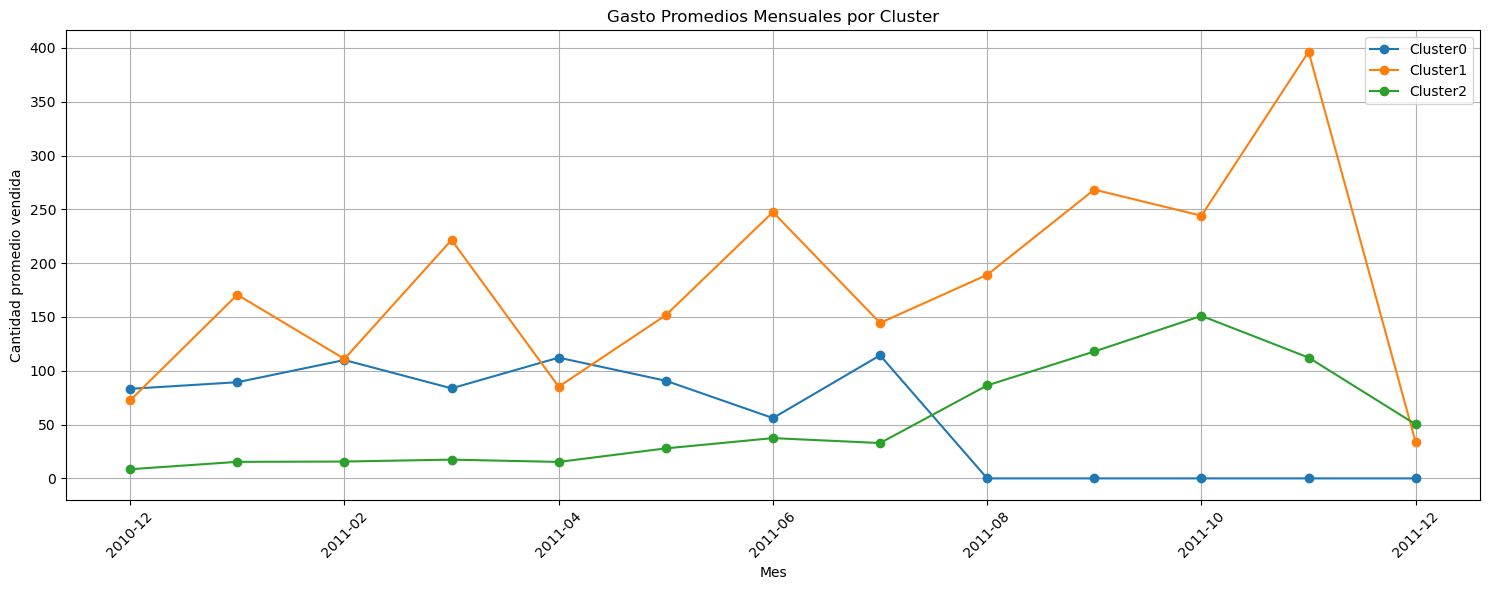

In [156]:
cluster0_mes= cluster_summary.iloc[0].T
cluster1_mes= cluster_summary.iloc[1].T
cluster2_mes= cluster_summary.iloc[2].T

columnas_fechas = [col for col in rfm_clientes_extranjeros_clean.columns if col.startswith('201')]

cluster0_mes=cluster0_mes[columnas_fechas]
cluster1_mes=cluster1_mes[columnas_fechas]
cluster2_mes=cluster2_mes[columnas_fechas]

ventas_promedios_mensuales=pd.concat([cluster0_mes,cluster1_mes,cluster2_mes],axis=1)
ventas_promedios_mensuales.columns=['Cluster0','Cluster1','Cluster2']

ventas_promedios_mensuales.plot(
    figsize=(15, 6),
    title='Gasto Promedios Mensuales por Cluster',
    marker='o' ,
    markersize=6 )

plt.xlabel("Mes")
plt.ylabel("Cantidad promedio vendida")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

##### RFM

In [157]:
rfm_columnas=['Recency', 'Frequency', 'Monetary']
cluster0_rfm=cluster_summary.iloc[0].T
cluster1_rfm=cluster_summary.iloc[1].T
cluster2_rfm=cluster_summary.iloc[2].T

cluster0_rfm=cluster0_rfm[rfm_columnas]
cluster1_rfm=cluster1_rfm[rfm_columnas]
cluster2_rfm=cluster2_rfm[rfm_columnas]

rfm_promedio_cluster=pd.concat([cluster0_rfm,cluster1_rfm,cluster2_rfm],axis=1)
rfm_promedio_cluster.columns=['Cluster 0','Cluster 1','Cluster 2']


In [158]:
rfm_promedio_cluster

,Cluster 0,Cluster 1,Cluster 2
Recency,228.036585,36.907692,50.300578
Frequency,1.524390,4.830769,1.988439
Monetary,739.726463,2336.477077,688.308266


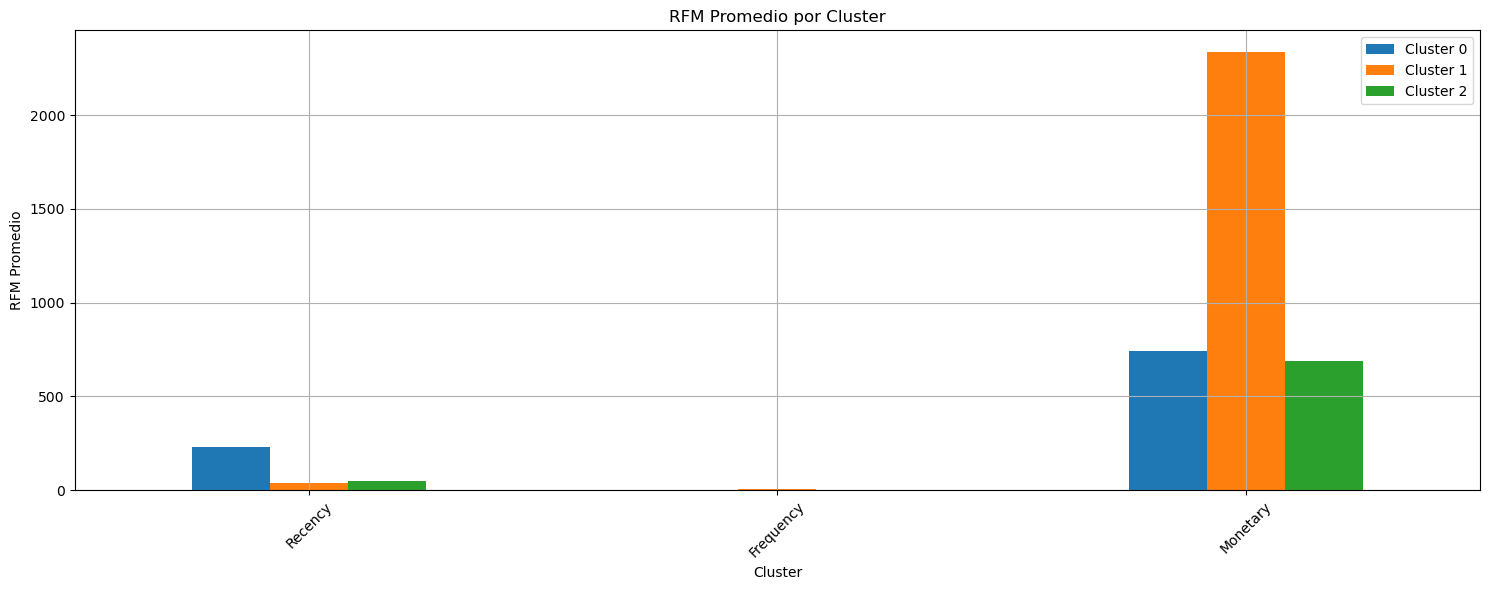

In [159]:
rfm_promedio_cluster.plot(kind='bar', figsize=(15, 6))
plt.title('RFM Promedio por Cluster')
plt.xlabel('Cluster')
plt.ylabel('RFM Promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [161]:
clientes_cluster=rfm_clientes_extranjeros_clean[['id_cliente','Cluster']].copy()

clientes_cluster.head()

print(clientes_cluster.shape)

clientes_cluster.to_csv('../../../dataset/clientes_cluster_extranjeros.csv', index=False)

(320, 2)
